In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
import os
homedir = os.path.expanduser('~')
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
import emcee
import scipy.stats as st
import arviz as az
import corner

In [3]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCK*_1f.spec.fits'))
fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [5]:
obs=22
order=5
wl_order = wls[obs, order, :] *10000
flux_order = fobs0[order]
data = Spectrum(wl_order, flux_order, sigmas=None, masks=None, name="Spectrum")
#fitted params:
# chisq = 346
# vsini = 30.45525347753552
# rv = 0.8606
# lld = 8.589e-05
# wcoef = [ 0.00024143 -0.00397479  0.03418952], [ 0.00024143 -0.00397479  0.03418952], [ 0.0002946  -0.00408566  0.03425189], [ 0.0002946  -0.00408566  0.03425189]
# ccoef = [2.45280359 0.2117408 ], [2.45280359 0.2117408 ]

### Setting up the model
Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: None

Parameters
  vsini: 25
  vz: 105
  cheb: [0]
  T: 1500
  logg: 5.0
  log_scale: 3.934758912387137 (fit)

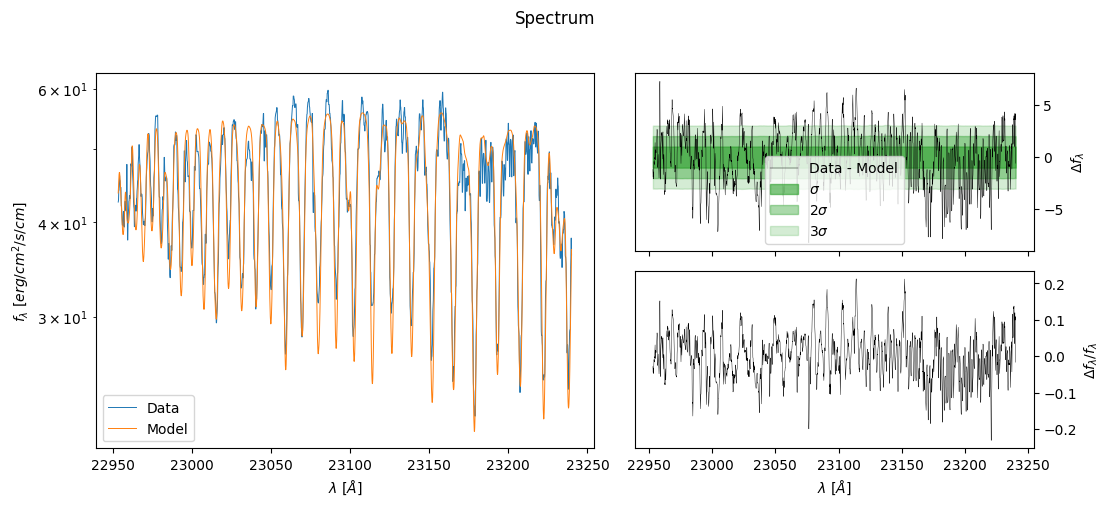

In [43]:
model = SpectrumModel(
    emulator="BTSettl_K_emu.hdf5",
    data=data,
    grid_params=[1500, 5.0],
    vsini=25,
    vz=105,
    cheb=[0]
)
model.plot()
model

#### MCMC Sampling

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [89]:
priors = {
    "T": st.norm(1500, 100),
    "vsini": st.norm(25, 0.2),
    "global_cov:log_amp": st.norm(0, 1),
    "global_cov:log_ls": st.uniform(0, 10),
}

In [70]:
priors = {
    "T": st.uniform(500,2500),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6)
}
model.log_likelihood(priors)

-8164.672374185593

In [71]:
#model.load("example_MAP_1.toml")
model.freeze("logg")
model.labels  # These are the fittable parameters

('vsini', 'vz', 'cheb:1', 'T')

Numerical Optimization

In [73]:
%time model.train(priors, options={"maxiter": 100})

CPU times: user 12min 26s, sys: 37min 3s, total: 49min 29s
Wall time: 53.7 s


 final_simplex: (array([[2.78621031e+01, 1.04384652e+02, 2.54238773e-01, 1.49279629e+03],
       [2.78623345e+01, 1.04384525e+02, 2.54256521e-01, 1.49280473e+03],
       [2.78635882e+01, 1.04384926e+02, 2.54016951e-01, 1.49280515e+03],
       [2.78637753e+01, 1.04385303e+02, 2.54262320e-01, 1.49278859e+03],
       [2.78626588e+01, 1.04384029e+02, 2.54133526e-01, 1.49280094e+03]]), array([4473.92988231, 4473.92989411, 4473.929953  , 4473.92997567,
       4473.93000175]))
           fun: 4473.92988230927
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 180
           nit: 100
        status: 2
       success: False
             x: array([2.78621031e+01, 1.04384652e+02, 2.54238773e-01, 1.49279629e+03])

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -4453.494310345825

Parameters
  vsini: 27.862334490237938
  vz: 104.3845246399193
  cheb: [0.25425652127661547]
  T: 1492.8047299439168
  log_scale: 3.7508132213279826 (fit)

Frozen Parameters
  logg: 5.0

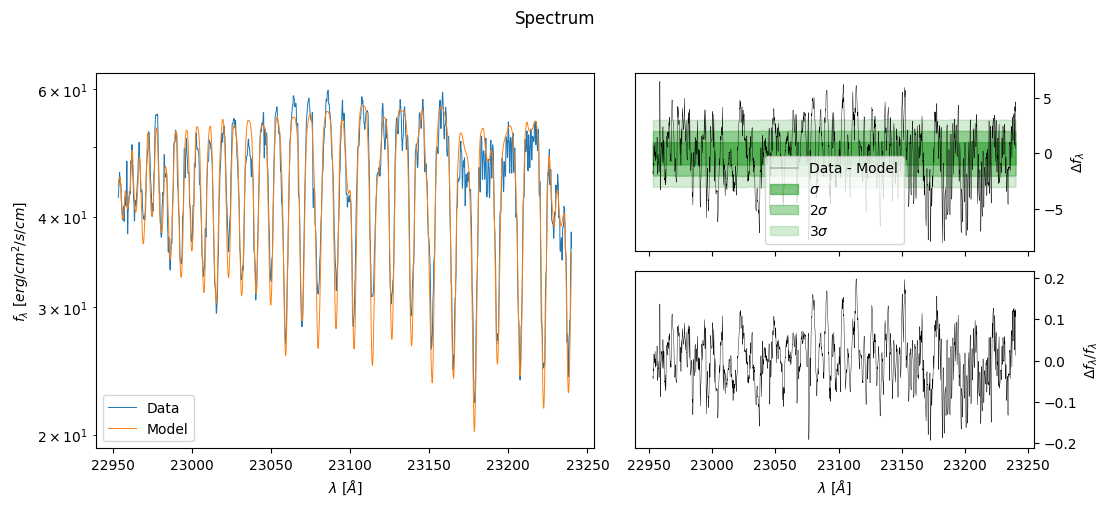

In [74]:
model.plot()
model

In [75]:
# Set our walkers and dimensionality
nwalkers = 10
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1, "cheb:1": 1}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [76]:
max_n = 500

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.02)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py:324: RuntimeWarning: invalid value encountered in log
  self._log_scale = np.log(scale)
 64%|██████▍   | 320/500 [16:46<09:25,  3.14s/it]

Converged at sample 320


Parallelized version

In [86]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

nwalkers = 100
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1}
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(priors,), backend=backend
    )

    max_n = 500

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
        # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
        # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau

  0%|          | 1/500 [00:33<4:37:54, 33.42s/it]Traceback (most recent call last):
  File "/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3116325/373837380.py", line 17, in log_prob
    return model.log_likelihood(priors)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 296, in __call__
    fluxes = resample(wave, fluxes, self.data.wave)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in resample
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) for fl in flux]
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in <listcomp>
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) fo

emcee: Exception while calling your likelihood function:
  params: [  23.88068875  107.39306848 1490.99562051]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18b0d0>, 'vsini': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055d8638e0>, 'vz': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18bfa0>},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [77]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True);

100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


#### MCMC Chain Analysis

In [78]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

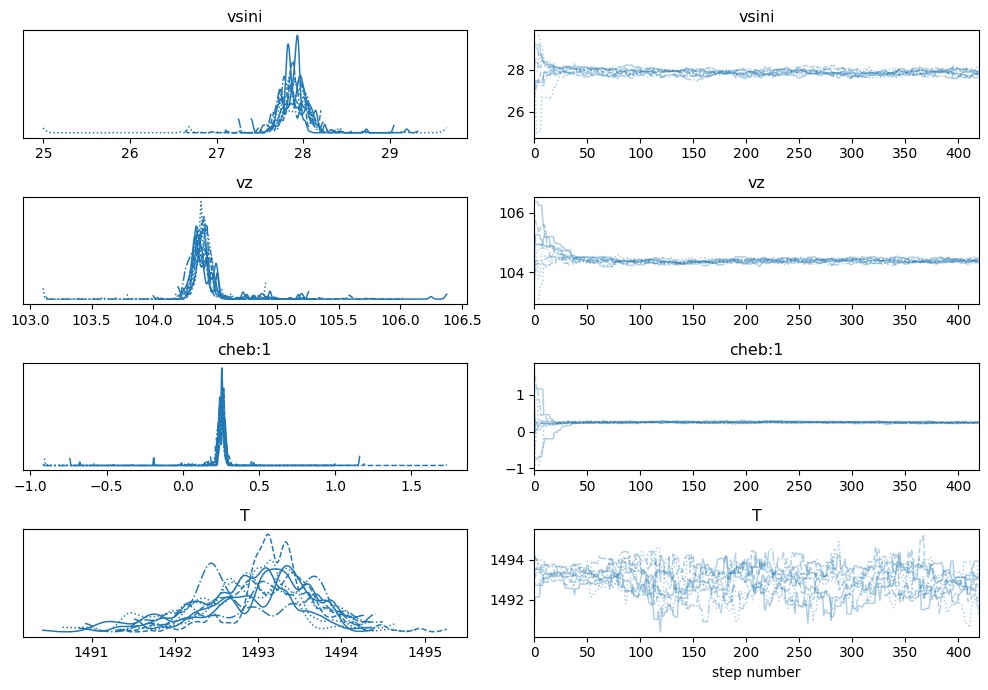

In [80]:
az.plot_trace(full_data, figsize=(10,7));
plt.xlabel("step number")
plt.tight_layout()

After seeing our full traces, let's discard and thin some of the burn-in

In [92]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

In [82]:
tau

array([23.94557306, 20.21631203, 11.19332814, 19.36631504])

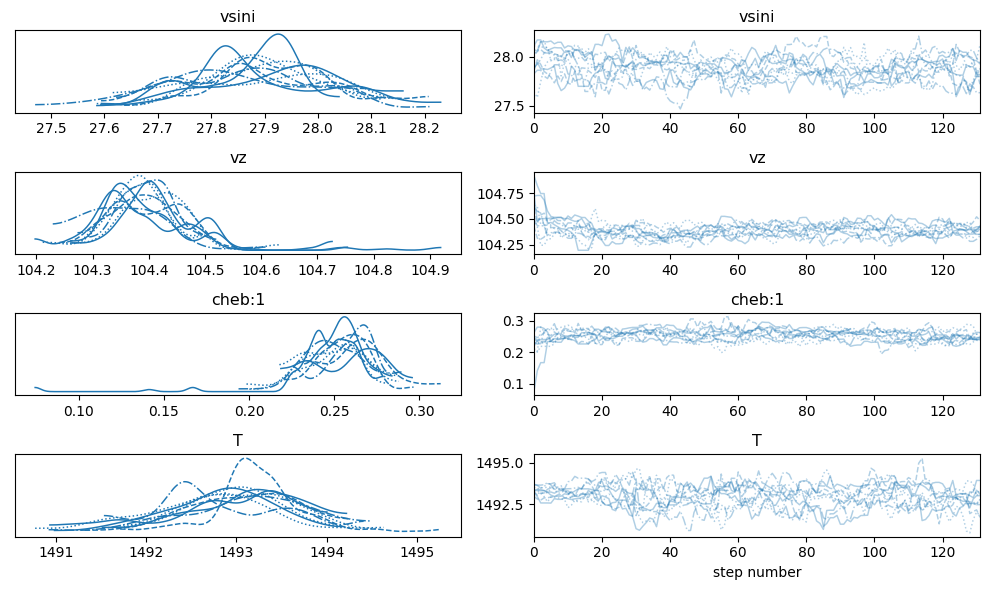

In [83]:
az.plot_trace(burn_data, figsize=(10,6));
plt.xlabel("step number")
plt.tight_layout()

In [88]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vsini,27.886,0.124,27.651,28.100,0.013,0.009,94.0,128.0,1.08
vz,104.391,0.070,104.277,104.517,0.006,0.004,106.0,143.0,1.08
cheb:1,0.253,0.018,0.221,0.283,0.003,0.002,50.0,213.0,1.14
T,1492.978,0.665,1491.592,1494.072,0.062,0.044,113.0,280.0,1.06


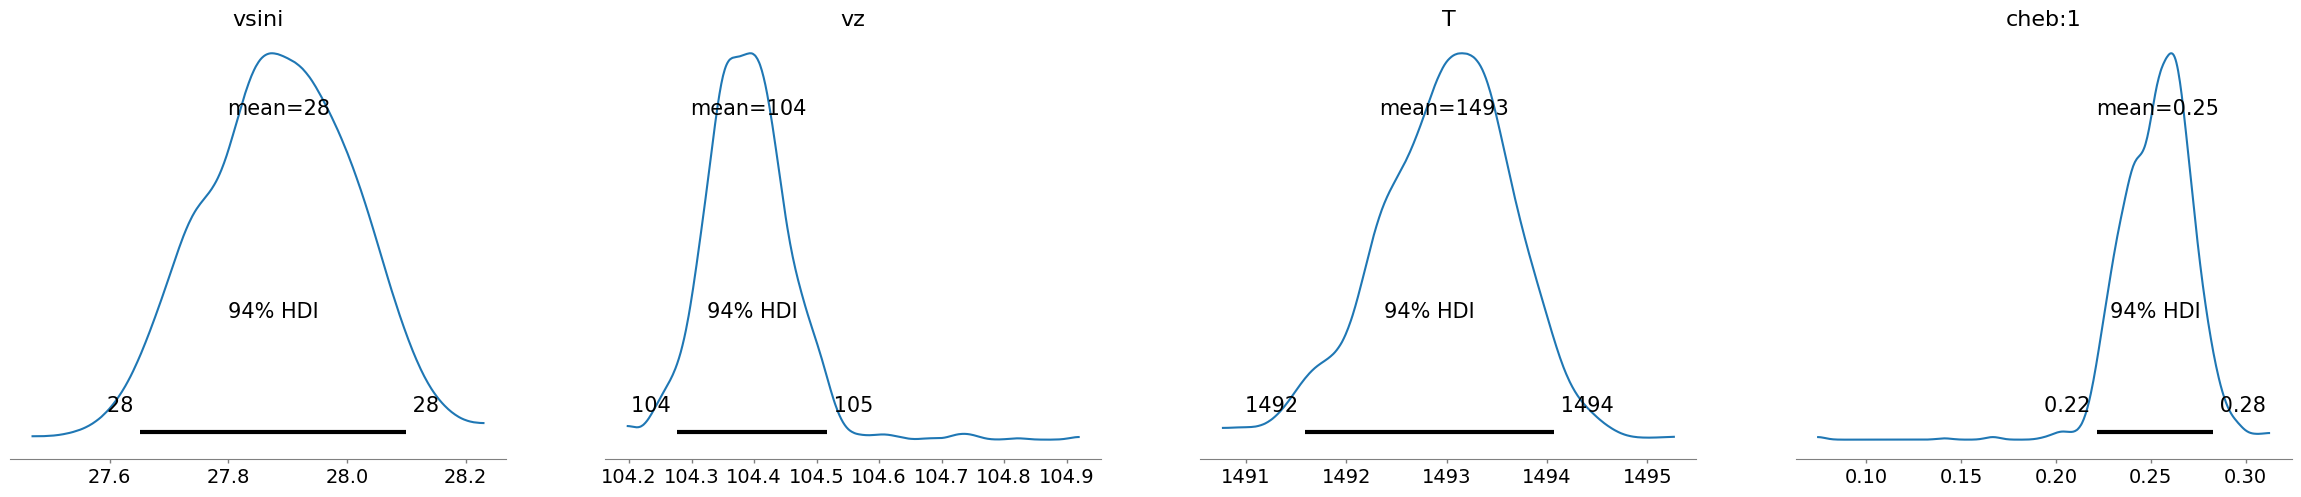

In [94]:
az.plot_posterior(burn_data, ["vsini", "vz", "T", "cheb:1"]);

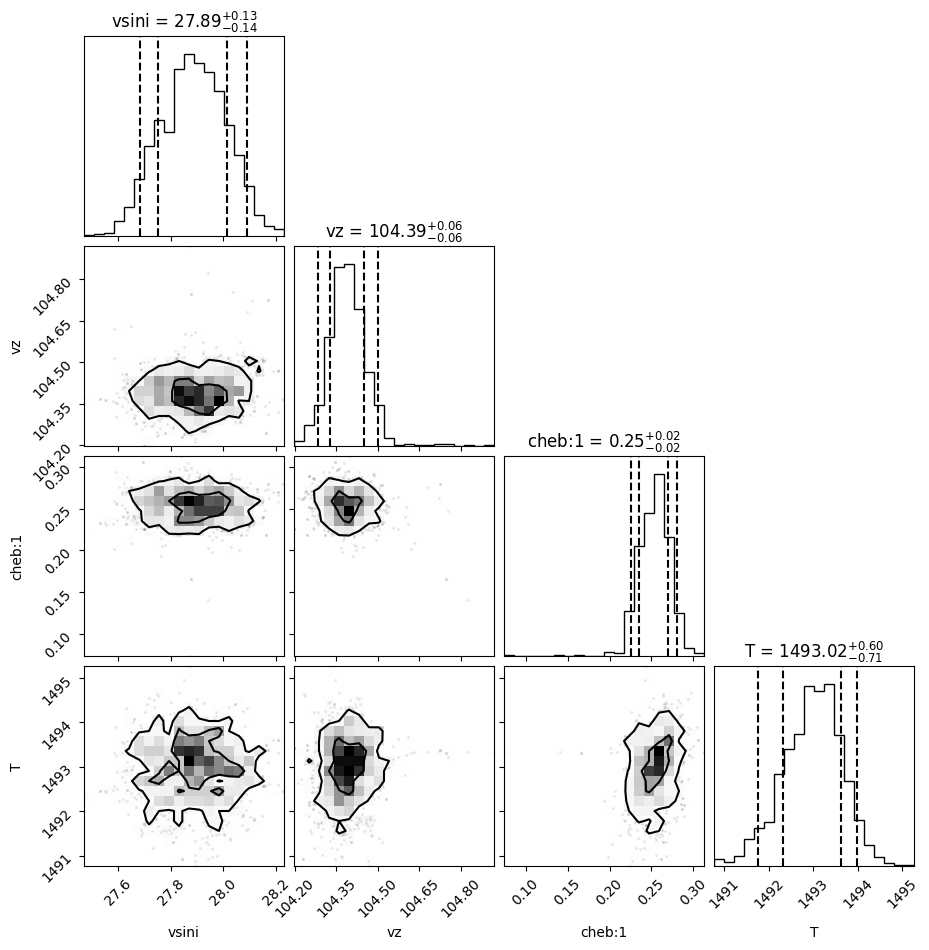

In [95]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
#all_samples = reader.get_chain()
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 4)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True
);

After looking at our posteriors, let's look at our fit

In [48]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -4575.647315659743

Parameters
  vsini: 27.878
  vz: 104.425
  T: 1489.836
  log_scale: 3.9537247848046557 (fit)

Frozen Parameters
  logg: 5.0

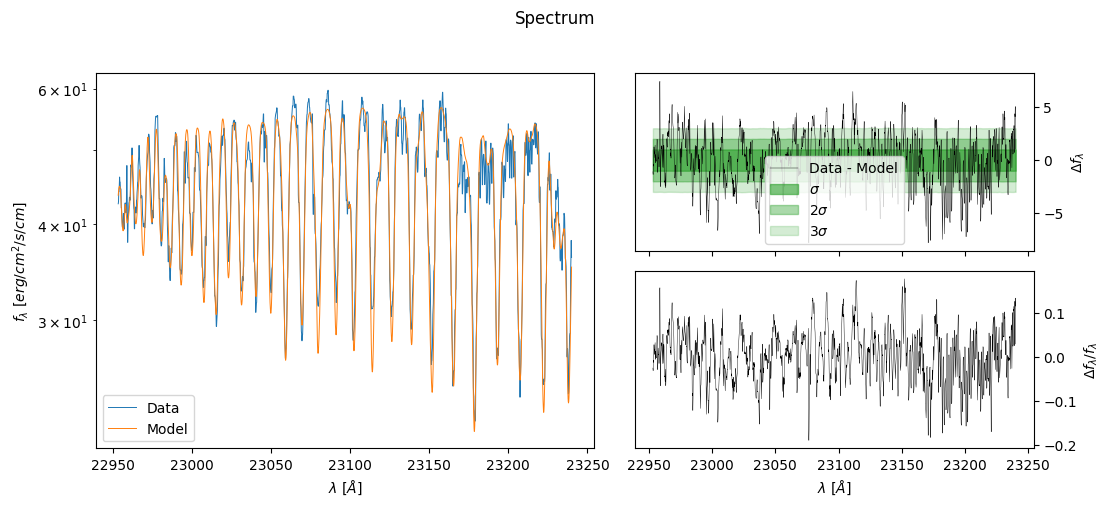

In [49]:
model.plot();

and finally, we can save our best fit.

In [50]:
model.save("example_sampled_1.toml")

Now, on to the next star!